# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
%reload_ext autoreload
%autoreload 2
import traceback
import numpy as np
import torch
from torch.utils.data import DataLoader
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import WhisperForConditionalGeneration, WhisperProcessor

from utils import audio, causal

# Load Models

In [3]:
try:
    del clean_model
    del corrupted_model
    print("Models deleted!")
except:
    pass

In [4]:
MODEL_NAME = "tiny.en"

clean_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
corrupted_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
processor = WhisperProcessor.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True)
eos_id = processor.tokenizer.eos_token_id

clean_model.eval()
corrupted_model.eval()

print("Done")

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Done


# Load Data

In [5]:
tedlium_path = "../tedlium"
path = f"{tedlium_path}/test.hf"

In [6]:
SELECT = 100

SEED = 1

data = load_from_disk(path).with_format("torch").shuffle(seed=SEED).select(range(SELECT))

In [7]:
dataloader = DataLoader(data)

# Register Hooks

In [8]:
activations = {}
debug_activations = {}
hooks = []
temp_hooks = []
activation_count = [0] # global

# Inference

In [9]:
def infer_with_probs(audio, model, processor):
    inputs = processor(audio, return_tensors="pt", sampling_rate=16_000)
    input_features = inputs.input_features.to(model.device)
    
    res = model.generate(input_features, return_dict_in_generate=True, output_scores=True)
    eos_probs = torch.tensor([torch.nn.Softmax(dim=0)(s.squeeze())[eos_id] for s in res["scores"]]) # get eos id for each token
    
    decoded = processor.decode(res.sequences.squeeze(), skip_special_tokens=True)
    return decoded, res, eos_probs

# Establish Clean Hooks

In [24]:
causal.reset(activations, debug_activations, hooks, temp_hooks)

In [25]:
causal.register_all_decoder_blocks(clean_model, causal.clean_hook, activations, hooks)

In [26]:
example = data[20]
wave = example["audio"]
example["text"]

'and some fish meals and then he said chicken pellets'

In [27]:
decoded, res, eos_probs = infer_with_probs(wave, clean_model, processor)
decoded

' and some fish meals and then he said chicken pellets.'

In [28]:
clean_probs = eos_probs.unsqueeze(1).repeat(1, 4) # to be used in finding effect

In [29]:
assert activations, "Activations is empty! Reverify"

# Corrupt Model and Run

In [30]:
# Verify model is sane before inserting hook
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd, p

(' and some fish meals and then he said chicken pellets.',
 tensor([0.0000e+00, 4.2728e-05, 3.6651e-06, 2.8615e-06, 2.3279e-04, 7.3043e-05,
         1.1265e-04, 1.8888e-05, 1.1879e-04, 4.4060e-04, 1.6771e-01, 9.9249e-01]))

In [31]:
embed_hook = causal.register_decoder_embedding_hook(corrupted_model, causal.corrupt_embed_hook, hooks, alpha=1)

In [32]:
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd

' and.'

# Restore Layer

In [ ]:
# results = []
# temp_holder = []
# try:
#     for token in tqdm.tqdm(range(len(activations[0])), desc="Tokens", leave=True):
#         blocks = []
#         for block in range(4):
#             correction_hook = causal.register_at_decoder_block(corrupted_model, causal.correction_hook, block, temp_holder, block, token, activations)
#             _, _, eos_prob = infer_with_probs(wave, corrupted_model, processor)
#             correction_hook.remove()
#             blocks.append(eos_prob[1])
#         results.append(torch.stack(blocks))
# except Exception as e:
#     correction_hook.remove()
#     traceback.print_exc()
# finally:
#     temp_holder.clear()
#     del temp_holder

In [ ]:
# results_total

In [ ]:
# results_total.shape

In [ ]:
# fig, ax = plt.subplots()
# ax = sns.heatmap(torch.abs(results_total - clean_probs), ax=ax)
# ax.set_xlabel("Restored Layer")
# ax.set_ylabel("Restored Token number")
# ax.set_title("Probability of EOS over restored tokens and layers")
# plt.show()

# Aggregate over many runs

In [34]:
results = []
temp_holder = []
total_effect = direct_effect = indirect_effect = 0

ITERS = 10

pbar = tqdm.tqdm(range(10), leave=True, ncols=0, desc="Aggregate")

try:
    for i in pbar:
        results.clear()
        causal.reset(activations, debug_activations, hooks, temp_hooks)
        causal.register_all_decoder_blocks(clean_model, causal.clean_hook, activations, hooks)

        # collect activations and find clean probs
        pbar.set_postfix_str("Clean run")
        _, _, clean_probs = infer_with_probs(wave, clean_model, processor)
        clean_probs = clean_probs.unsqueeze(1).repeat(1, 4)
        assert activations, "Activations is empty! Reverify"

        # corrupt model and find corrupt probs
        pbar.set_postfix_str("Corrupted run")
        embed_hook = causal.register_decoder_embedding_hook(corrupted_model, causal.corrupt_embed_hook, hooks, alpha=3)
        _, _, corrupt_probs = infer_with_probs(wave, corrupted_model, processor)
        corrupt_probs = corrupt_probs.unsqueeze(1).repeat(1, 4)
        corrupt_probs = torch.nn.functional.pad(corrupt_probs, (0, 0, 0, clean_probs.size(0) - corrupt_probs.size(0)), value=1.0)

        # sequentially correct layers at tokens
        for token in range(len(activations[0])):
            pbar.set_postfix_str(f"Corrupted run with correction: {token + 1}/{len(activations[0])}")
            blocks = []
            for block in range(4):
                correction_hook = causal.register_at_decoder_block(corrupted_model, causal.correction_hook, block, temp_holder, block, token, activations)
                _, _, correction_probs = infer_with_probs(wave, corrupted_model, processor)
                correction_hook.remove()
                blocks.append(correction_probs[1])
            results.append(torch.stack(blocks))
        correction_probs = torch.stack(results)
        
        # TE, DE and IE
        total_effect += clean_probs - corrupt_probs
        direct_effect += clean_probs - correction_probs
        indirect_effect += correction_probs - corrupt_probs
        
except Exception as e:
    correction_hook.remove()
    traceback.print_exc()
finally:
    temp_holder.clear()

Aggregate: 100% 10/10 [12:03<00:00, 72.38s/it, Corrupted run with correction: 12/12]


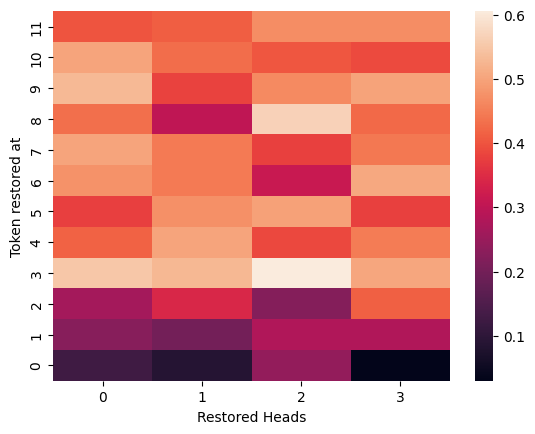

In [53]:
# IE = P(eot | correction) - P(eot | corrupted)

ax = sns.heatmap(torch.abs(indirect_effect / 10))
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
ax.invert_yaxis()
plt.show()

In [ ]:
indirect_effect

In [ ]:
# TE = P(eot | clean) - P(eot | corrupted)

ax = sns.heatmap(total_effect / 10)
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
plt.show()

In [ ]:
# DE = P(eot | correction) - P(eot | )

ax = sns.heatmap(direct_effect / 10)
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
plt.show()

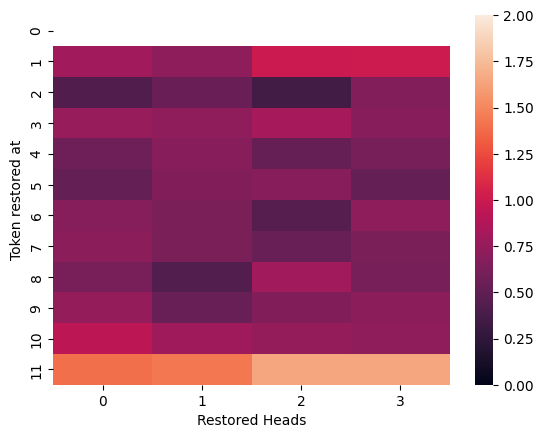

In [43]:
# IE / TE

ax = sns.heatmap(torch.abs(indirect_effect) / torch.abs(total_effect), vmin=0.0, vmax=2.0)
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
plt.show()

In [37]:
indirect_effect / 10

tensor([[ 0.1253,  0.0875,  0.2423,  0.0297],
        [-0.2258, -0.2006, -0.2805, -0.2814],
        [-0.2644, -0.3415, -0.2225, -0.4143],
        [-0.5507, -0.5275, -0.6060, -0.5030],
        [-0.4156, -0.5008, -0.3875, -0.4462],
        [-0.3746, -0.4737, -0.4972, -0.3765],
        [-0.4755, -0.4458, -0.3144, -0.5049],
        [-0.5016, -0.4458, -0.3766, -0.4425],
        [-0.4314, -0.3000, -0.5675, -0.4253],
        [-0.5312, -0.3794, -0.4655, -0.4981],
        [-0.5018, -0.4294, -0.4025, -0.3882],
        [-0.3989, -0.4106, -0.4707, -0.4708]])

In [38]:
total_effect / 10

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2814, -0.2814, -0.2814, -0.2814],
        [-0.6283, -0.6283, -0.6283, -0.6283],
        [-0.7339, -0.7339, -0.7339, -0.7339],
        [-0.7365, -0.7365, -0.7365, -0.7365],
        [-0.7259, -0.7259, -0.7259, -0.7259],
        [-0.7055, -0.7055, -0.7055, -0.7055],
        [-0.7069, -0.7069, -0.7069, -0.7069],
        [-0.7063, -0.7063, -0.7063, -0.7063],
        [-0.7110, -0.7110, -0.7110, -0.7110],
        [-0.5391, -0.5391, -0.5391, -0.5391],
        [ 0.2861,  0.2861,  0.2861,  0.2861]])

In [ ]:
corrupt_probs

In [ ]:
clean_probs

In [40]:
torch.abs(indirect_effect) / torch.abs(total_effect)

tensor([[   inf,    inf,    inf,    inf],
        [0.8026, 0.7130, 0.9970, 1.0000],
        [0.4208, 0.5436, 0.3541, 0.6594],
        [0.7504, 0.7188, 0.8257, 0.6854],
        [0.5642, 0.6799, 0.5262, 0.6059],
        [0.5160, 0.6526, 0.6849, 0.5187],
        [0.6740, 0.6320, 0.4456, 0.7158],
        [0.7096, 0.6306, 0.5328, 0.6260],
        [0.6108, 0.4248, 0.8035, 0.6022],
        [0.7471, 0.5336, 0.6548, 0.7005],
        [0.9307, 0.7965, 0.7466, 0.7200],
        [1.3940, 1.4349, 1.6449, 1.6452]])